Step 1: Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error



Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [2]:
df = pd.read_csv("household.csv")

In [3]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [ ]:

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')


df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
)

df_hour = df_hour.asfreq('H').interpolate()

df_hour = df_hour.reset_index()

print("After hourly resample + fill:", len(df_hour))
df_hour.head()


After hourly resample + fill: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500


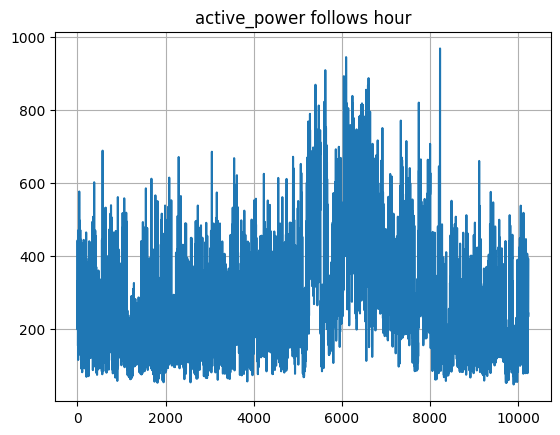

In [5]:
series = df_hour['active_power']
# Plot data
plt.plot(series.index, series)
plt.title("active_power follows hour")
plt.grid(True)
plt.show()

Step 3. Implement models

3.5 ARIMA


 3.5.1. ADF Test and Determining the Differencing Order d

In [ ]:
def adf_test(series, name=""):
    print(f"\n=== ADF Test: {name} ===")
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for k,v in result[4].items():
        print(f"  {k}: {v}")
    return result[1]

pvalue0 = adf_test(series, "Original Series")

d = 0
temp = series.copy()

while pvalue0 > 0.05 and d < 2:
    d += 1
    temp = series.diff(d).dropna()
    pvalue0 = adf_test(temp, f"Diff {d}")

print("\n=> Differencing Order d =", d)



=== ADF Test: Original Series ===
ADF Statistic: -6.298645185513371
p-value: 3.455608142286192e-08
  1%: -3.430991646794122
  5%: -2.8618235703087764
  10%: -2.566920939332377

=> Differencing Order d = 0


3.5.2. ACF / PACF to choose p, q

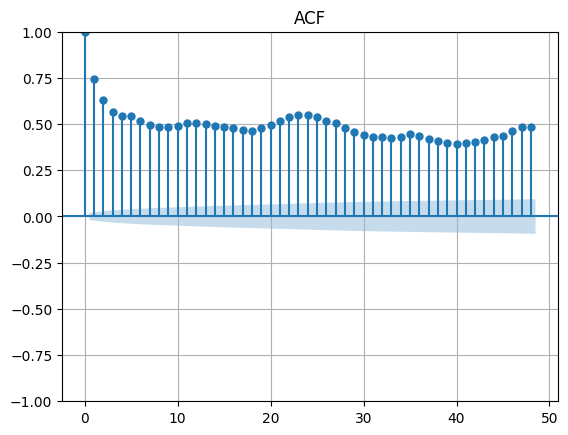

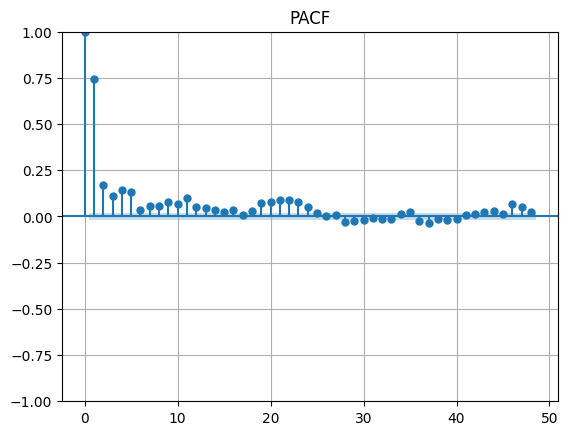


Choose p based on PACF (cut-off). Choose q based on ACF.



In [7]:
if d > 0:
    series_diff = series.diff(d).dropna()
else:
    series_diff = series.copy()

lags = 48

plot_acf(series_diff, lags=lags)
plt.title("ACF")
plt.grid(True)
plt.show()

plot_pacf(series_diff, lags=lags, method='ywm')
plt.title("PACF")
plt.grid(True)
plt.show()

print("\nChoose p based on PACF (cut-off). Choose q based on ACF.\n")

3.5.3. Train/Validate/Test split

Train: 8698 Validate: 1024 Test: 512


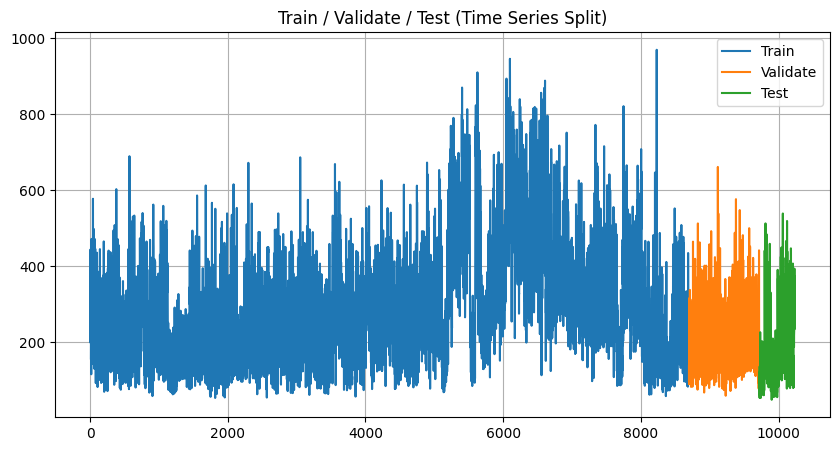

In [ ]:
n = len(series)


train_end = int(n * 0.85)   
val_end   = int(n * 0.95)   

train = series.iloc[:train_end]
validate = series.iloc[train_end:val_end]
test = series.iloc[val_end:]

print("Train:", len(train), 
      "Validate:", len(validate), 
      "Test:", len(test))

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.legend()
plt.grid(True)
plt.title("Train / Validate / Test (Time Series Split)")
plt.show()


3.5.4. Grid-search to choose p,q optimally

In [9]:
import math   

results = []

for p_test in range(0, 4):
    for q_test in range(0, 4):
        try:
            model = ARIMA(train, order=(p_test, d, q_test)).fit()
            pred_val = model.forecast(steps=len(validate))
            rmse_val = math.sqrt(mean_squared_error(validate, pred_val))

            results.append({
                'Model': f'ARIMA({p_test},{d},{q_test})',
                'AIC': model.aic,
                'BIC': model.bic,
                'RMSE_Val': rmse_val
            })

        except Exception as e:
            print(f"FAILED: ARIMA({p_test},{d},{q_test}) → {e}")

df_results = pd.DataFrame(results)
print("\nGRID SEARCH :")
print(df_results)


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



GRID SEARCH :
           Model            AIC            BIC    RMSE_Val
0   ARIMA(0,0,0)  111049.092261  111063.233957  121.650871
1   ARIMA(0,0,1)  107003.184797  107024.397342  121.556511
2   ARIMA(0,0,2)  105461.156460  105489.439853  121.529677
3   ARIMA(0,0,3)  104894.083213  104929.437455  121.486009
4   ARIMA(1,0,0)  104080.332940  104101.545486  121.183447
5   ARIMA(1,0,1)  103726.677390  103754.960784  120.756983
6   ARIMA(1,0,2)  103261.104114  103296.458356  116.695745
7   ARIMA(1,0,3)  103009.780094  103052.205184  113.012636
8   ARIMA(2,0,0)  103862.092709  103890.376102  121.037988
9   ARIMA(2,0,1)  103013.614812  103048.969054  111.415669
10  ARIMA(2,0,2)  104790.041512  104832.466602  122.475850
11  ARIMA(2,0,3)  102999.347930  103048.843869  112.191566
12  ARIMA(3,0,0)  103756.585119  103791.939361  120.882981
13  ARIMA(3,0,1)  103015.475405  103057.900495  111.483422
14  ARIMA(3,0,2)  103016.327784  103065.823723  111.657907
15  ARIMA(3,0,3)  103001.398014  103057.9

In [ ]:
df_results = pd.DataFrame(results)

df_results_sorted = df_results.sort_values(
    by=['RMSE_Val', 'AIC'], 
    ascending=[True, True]
)

print("\n=== ARIMA Model Ranking  ===")
print(df_results_sorted)

best_model = df_results_sorted.iloc[0]
print("\n=== Optimal ARIMA Model ===")
print(best_model)



=== ARIMA Model Ranking  ===
           Model            AIC            BIC    RMSE_Val
9   ARIMA(2,0,1)  103013.614812  103048.969054  111.415669
13  ARIMA(3,0,1)  103015.475405  103057.900495  111.483422
14  ARIMA(3,0,2)  103016.327784  103065.823723  111.657907
15  ARIMA(3,0,3)  103001.398014  103057.964801  112.079956
11  ARIMA(2,0,3)  102999.347930  103048.843869  112.191566
7   ARIMA(1,0,3)  103009.780094  103052.205184  113.012636
6   ARIMA(1,0,2)  103261.104114  103296.458356  116.695745
5   ARIMA(1,0,1)  103726.677390  103754.960784  120.756983
12  ARIMA(3,0,0)  103756.585119  103791.939361  120.882981
8   ARIMA(2,0,0)  103862.092709  103890.376102  121.037988
4   ARIMA(1,0,0)  104080.332940  104101.545486  121.183447
3   ARIMA(0,0,3)  104894.083213  104929.437455  121.486009
2   ARIMA(0,0,2)  105461.156460  105489.439853  121.529677
1   ARIMA(0,0,1)  107003.184797  107024.397342  121.556511
0   ARIMA(0,0,0)  111049.092261  111063.233957  121.650871
10  ARIMA(2,0,2)  104790.0

In [11]:
import re

best_model_name = best_model['Model']
p, d, q = map(int, re.findall(r'\d+', best_model_name))

print("p =", p)
print("d =", d)
print("q =", q)

p = 2
d = 0
q = 1


3.5.5. Predict Test

                               SARIMAX Results                                
Dep. Variable:           active_power   No. Observations:                 9722
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -57430.828
Date:                Mon, 24 Nov 2025   AIC                         114871.656
Time:                        21:04:57   BIC                         114907.567
Sample:                             0   HQIC                        114883.829
                               - 9722                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        290.8233     22.954     12.670      0.000     245.833     335.813
ar.L1          1.4543      0.010    149.521      0.000       1.435       1.473
ar.L2         -0.4569      0.009    -48.124      0.0

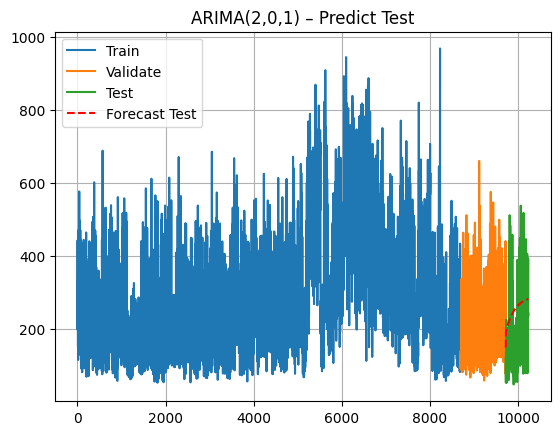

In [ ]:
train_val = series.iloc[:val_end]

model_tv = ARIMA(train_val, order=(p, d, q))
model_tv_fit = model_tv.fit()

print(model_tv_fit.summary())
print("AIC:", model_tv_fit.aic)
print("BIC:", model_tv_fit.bic)

test_pred = model_tv_fit.forecast(steps=len(test))
test_pred.index = test.index

mae_test = mean_absolute_error(test, test_pred)
mape_test = np.mean(np.abs((test - test_pred) / test)) * 100
rmse_test = math.sqrt(mean_squared_error(test, test_pred))

print("\n===== Optimal Model Evaluation Results =====")
print("MAE Test :", mae_test)
print("MAPE Test:", mape_test)
print("RMSE Test:", rmse_test)

plt.plot(train, label='Train')
plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.plot(test_pred, label='Forecast Test', linestyle='--', color='red')
plt.legend()
plt.grid(True)
plt.title(f'ARIMA({p},{d},{q}) – Predict Test')
plt.show()